In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import torch
from datasets import load_dataset
from datasets import Audio as dsets_Audio
from torchaudio.pipelines import HUBERT_BASE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RATE = 16_000  # sample rate
print(DEVICE)

cuda


In [2]:
def simplify_audio_column(item):
    item["audio"] = item["audio"]["array"]
    return item

gtzan = load_dataset("marsyas/gtzan", split='all')
gtzan = gtzan.train_test_split(seed=42, shuffle=True, test_size=0.1, stratify_by_column = 'genre')
gtzan = gtzan.cast_column("audio", dsets_Audio(sampling_rate=RATE))
gtzan = gtzan.map(simplify_audio_column)
gtzan.set_format("torch", columns=["audio"], output_all_columns=True)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})

In [3]:
id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(gtzan["train"][0]["genre"])
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan["train"].features["genre"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

'pop'

In [4]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
def collate_fn(batch):
    # HuBERT also expects original audio lengths -- other models might want masks
    lengths = torch.tensor([len(x["audio"]) for x in batch])
    tensors = pad_sequence([x["audio"] for x in batch],
                           batch_first=True,
                           padding_value=0.)
    targets = torch.tensor([x["genre"] for x in batch])
    return (tensors, lengths), targets

BATCH_SIZE = 16
    
train_loader = DataLoader(gtzan["train"], batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(gtzan["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn)
len(train_loader), len(val_loader)

(57, 7)

In [5]:
a_batch = next(iter(train_loader))
a_batch

((tensor([[-0.0766, -0.1531, -0.1149,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0032,  0.0033,  0.0009,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0099,  0.0174,  0.0254,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0152,  0.0372,  0.0430,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0346,  0.0190,  0.1842,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0551,  0.0250,  0.1863,  ...,  0.0366, -0.0638,  0.0000]]),
  tensor([480214, 480214, 480003, 480214, 480214, 480214, 480214, 480003, 480214,
          480003, 480003, 480214, 480214, 480214, 480003, 484340])),
 tensor([9, 0, 6, 5, 9, 5, 2, 8, 1, 6, 6, 9, 9, 1, 7, 5]))

In [6]:
from torchinfo import summary
from torchaudio.pipelines import HUBERT_BASE

hubert = HUBERT_BASE.get_model()
summary(hubert.feature_extractor, depth=5, input_data=a_batch[0], col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FeatureExtractor                         [16, 484340]              [16, 1513, 512]           --
├─ModuleList: 1-1                        --                        --                        --
│    └─ConvLayerBlock: 2-1               [16, 1, 484340]           [16, 512, 96867]          --
│    │    └─Conv1d: 3-1                  [16, 1, 484340]           [16, 512, 96867]          5,120
│    │    └─GroupNorm: 3-2               [16, 512, 96867]          [16, 512, 96867]          1,024
│    └─ConvLayerBlock: 2-2               [16, 512, 96867]          [16, 512, 48433]          --
│    │    └─Conv1d: 3-3                  [16, 512, 96867]          [16, 512, 48433]          786,432
│    └─ConvLayerBlock: 2-3               [16, 512, 48433]          [16, 512, 24216]          --
│    │    └─Conv1d: 3-4                  [16, 512, 48433]          [16, 512, 24216]          786,432
│    └─ConvLayerBlo

In [7]:
hubert.feature_extractor

FeatureExtractor(
  (conv_layers): ModuleList(
    (0): ConvLayerBlock(
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
    )
    (1-4): 4 x ConvLayerBlock(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
    )
    (5-6): 2 x ConvLayerBlock(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
    )
  )
)

In [8]:
del hubert

In [53]:
# Hypothesis: attention isn't actually necessary for this tasK: we can do it all
# using a CNN comparable to HuBERT's feature extractor.
# Since audio signals are very large, I'm going to use "dilated convolutions"
# à la WaveNet, arXiv:1609.03499v2.
from torch import nn

class SigmoidTanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.tanh(x) * self.sigmoid(x)
    
    
class ConvBlock(nn.Module):
    def __init__(self, num_filters, kernel_size=2, padding=1, dilation=2, stride=2,
                 bias=False, padding_mode="replicate", dropout=0.2):
        super().__init__()
        self.steps = nn.Sequential(
            nn.Conv1d(num_filters, num_filters,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      dilation=dilation,
                      padding_mode=padding_mode,
                      bias=bias),
            SigmoidTanh(),
            nn.Dropout(dropout),
        )
        self.pool = nn.AvgPool1d(kernel_size, stride, padding-1)
        
    def forward(self, x):
        pool = self.pool(x)
        steps = self.steps(x)
        # print(x.shape, pool.shape, steps.shape)
        return pool + steps
        

class AudioCNN(nn.Module):
    def __init__(self, num_filters=100, dropout=0.2):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv1d(1, num_filters, kernel_size=5, padding=1, stride=5, bias=False),
            nn.GroupNorm(num_filters, num_filters, eps=1e-05, affine=True),
            ConvBlock(num_filters, 2, 1, 2, 2, dropout=dropout),
            # Warning: These numbers are super finicky, since AvgPool1d and Conv1d
            # do slightly different calculations for the number of outputs.
            ConvBlock(num_filters, 2, 1, 4, 4, dropout=dropout),
            ConvBlock(num_filters, 2, 1, 8, 8, dropout=dropout),
            ConvBlock(num_filters, 2, 1, 15, 15, dropout=dropout),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100*num_filters, 100),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            # nn.Linear(100, 10),
        )
            
        
    def forward(self, x):
        x = x.unsqueeze(1)  # shape [batch, 1, samples]
        x = self.convs(x)
        x = self.classifier(x)
        return x
    
# To make things easier, I'm also going to redefine the DataLoader so that everything's a constant length
def collate_fn_trimmed(batch):
    audios = [x["audio"] for x in batch]
    seq_len = 480000
    # pad first seq to desired length
    audios[0] = nn.ConstantPad1d((0, seq_len - audios[0].shape[0]), 0.)(audios[0])
    # pad all seqs to desired length
    audios = pad_sequence(audios, batch_first=True, padding_value=0.)
    # trim to desired length
    audios = audios[:, :seq_len]
    targets = torch.tensor([x["genre"] for x in batch])
    return audios, targets


In [47]:
BATCH_SIZE = 16
    
train_loader = DataLoader(gtzan["train"], batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn_trimmed)
val_loader = DataLoader(gtzan["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn_trimmed)
len(train_loader), len(val_loader)

(57, 7)

In [29]:
a_batch = next(iter(train_loader))
a_batch

(tensor([[-0.1074, -0.0855, -0.0949,  ...,  0.0846,  0.0909,  0.1448],
         [-0.0317, -0.0333,  0.0003,  ..., -0.0100, -0.0033,  0.0020],
         [ 0.0181,  0.0339,  0.0390,  ...,  0.1382,  0.1452,  0.1686],
         ...,
         [-0.0168, -0.0492, -0.0534,  ..., -0.0361, -0.0006,  0.0034],
         [ 0.1575,  0.1769,  0.0921,  ..., -0.0881, -0.0263, -0.1228],
         [-0.0876, -0.1557, -0.1459,  ...,  0.2084,  0.2063,  0.1609]]),
 tensor([7, 2, 9, 8, 8, 0, 4, 5, 0, 6, 9, 8, 1, 0, 7, 8]))

In [30]:
a_batch[0].shape

torch.Size([16, 480000])

In [55]:
model = AudioCNN(num_filters=5, dropout=0.4).to(DEVICE)

model.convs(a_batch[0].to(DEVICE).unsqueeze(1)).shape


torch.Size([16, 5, 100])

In [36]:
model(a_batch[0].to(DEVICE)).shape

torch.Size([16, 10])

In [14]:
a_batch[0].shape

torch.Size([16, 480000])

In [67]:
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder

model = AudioCNN(num_filters=5, dropout=0.6).to(DEVICE)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.11E-03


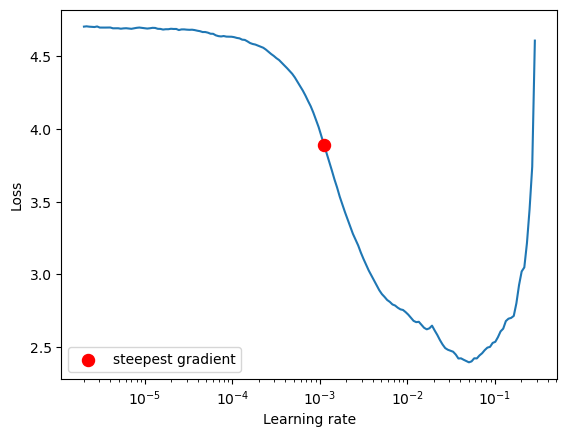

In [64]:
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, start_lr = 1e-6, end_lr=1, num_iter=200,
                     accumulation_steps=2)
lr_finder.plot()
lr_finder.reset()

In [65]:
summary(model, depth=3, input_data=a_batch[0].to(DEVICE), col_names=["input_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
AudioCNN                                 [16, 480000]              [16, 100]                 --                        --
├─Sequential: 1-1                        [16, 1, 480000]           [16, 5, 100]              --                        --
│    └─Conv1d: 2-1                       [16, 1, 480000]           [16, 5, 96000]            25                        38,400,000
│    └─GroupNorm: 2-2                    [16, 5, 96000]            [16, 5, 96000]            10                        160
│    └─ConvBlock: 2-3                    [16, 5, 96000]            [16, 5, 48000]            --                        --
│    │    └─AvgPool1d: 3-1               [16, 5, 96000]            [16, 5, 48000]            --                        --
│    │    └─Sequential: 3-2              [16, 5, 96000]            [16, 5, 48000]            50                        38,400,000


  0%|          | 0/100 [00:00<?, ?it/s]

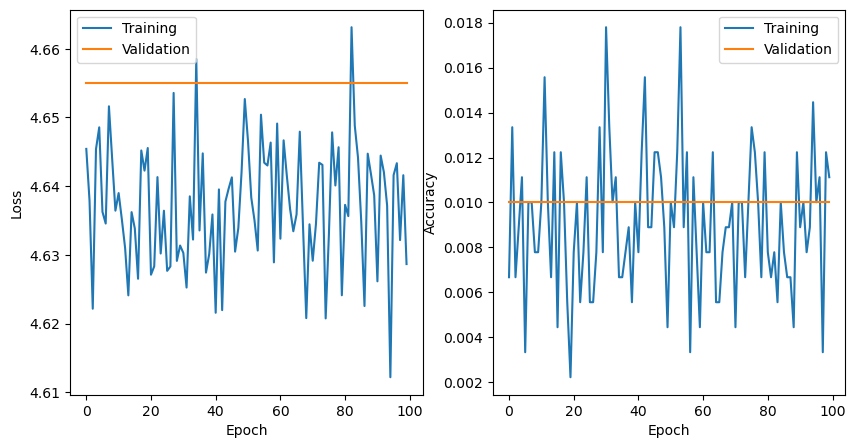

In [68]:
lr = 1e-3
n_epochs = 100
from tqdm.auto import tqdm


def val_step(batch):
    with torch.inference_mode():
        val_outputs = model(batch[0].to(DEVICE))
        val_loss = criterion(val_outputs, batch[1].to(DEVICE))
    return val_outputs, val_loss

def train_val_loop(n_epochs, grad_accum=None, save_every=None):
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for i in tqdm(range(n_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for j, batch in enumerate(train_loader):
            if grad_accum is not None and j % grad_accum == 0:
                optimizer.zero_grad()
            outputs = model(batch[0].to(DEVICE))
            loss = criterion(outputs, batch[1].to(DEVICE))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            outputs, loss = val_step(batch)
            val_loss += loss.item()
            val_acc += sum(torch.argmax(outputs.detach().cpu(), dim=1)
                             == batch[1]).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        
        if save_every is not None and (i+1) % save_every == 0:
            torch.save(model.state_dict(), f"../trained_models/Wavenet-epoch-{i+1}.pth")
        
    return metrics

metrics = train_val_loop(n_epochs, grad_accum=2, save_every=10)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(np.arange(n_epochs), metrics["train_loss"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();
plt.subplot(122)
plt.plot(np.arange(n_epochs), metrics["train_acc"], label="Training")
plt.plot(np.arange(n_epochs), metrics["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();
        